Authors: Aaryan Mahipal, Amelia Roopnarine 

STEP 1: Data Preperation

In [ ]:
# Task 1.1: Load and Explore the Data

import numpy as np
import matplotlib.pyplot as plt

# Define the function to load the fluid flow data
def load_fluid_flow_data(file_path):
    """
    Load fluid flow data from a file and return it as a numpy array.
    
    Parameters:
    file_path (str): Path to the data file
    
    Returns:
    np.array: 3D array of shape (n_timesteps, n_x, n_y) containing fluid flow data
    """
    return np.load(file_path)

# Load the dataset
file_path = 'cylinder_flow_data.npy'
fluid_flow_data = load_fluid_flow_data(file_path)


In [4]:
def plot_flow_field(flow_data, timestep):
    """
    Plot the flow field at a given timestep.
    
    Parameters:
    flow_data (np.array): 3D array of fluid flow data
    timestep (int): Timestep to plot
    """
    # Ensure the timestep is within the bounds of the data
    if timestep < 0 or timestep >= flow_data.shape[0]:
        raise ValueError(f"Timestep must be between 0 and {flow_data.shape[0] - 1}.")
    
    # Extract the flow field for the given timestep
    flow_field = flow_data[timestep]
    
    # Plot the flow field using imshow
    plt.figure(figsize=(8, 4))
    plt.imshow(flow_field, extent=[-2, 4, -1, 1], aspect='equal', cmap='viridis')
    plt.colorbar(label='Flow Field Value')
    plt.title(f'Flow Field at Timestep {timestep}')
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.show()

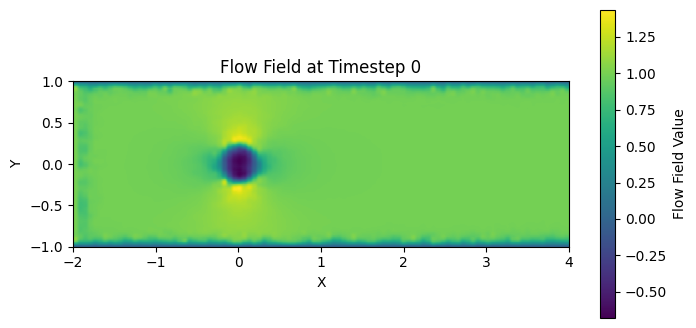

In [5]:
# Example usage
data = load_fluid_flow_data('cylinder_flow_data.npy')
plot_flow_field(data, timestep=0)

In [6]:
# Task 1.2: Reshape the data for DMD
def reshape_for_dmd(flow_data):
    """
    Reshape 3D flow data into a 2D matrix suitable for DMD.
    
    Parameters:
    flow_data (np.array): 3D array of shape (n_timesteps, n_x, n_y)
    
    Returns:
    np.array: 2D array of shape (n_x * n_y, n_timesteps)
    """
    # Get the shape of the 3D data
    n_timesteps, n_x, n_y = flow_data.shape
    
    # Reshape into a 2D array with each column as a flattened snapshot for each timestep
    reshaped_data = flow_data.reshape(n_timesteps, n_x * n_y).T
    return reshaped_data

# Apply the reshape function to the fluid flow data
dmd_data_matrix = reshape_for_dmd(fluid_flow_data)

# Check the shape of the reshaped data for verification
dmd_data_matrix.shape


(10000, 100)

STEP 2: Implementing the DMD Algorithm 

In [8]:
# Task 2.1: Compute the DMD Matrices
def compute_dmd_matrices(X):
    """
    Compute the matrices needed for DMD analysis.
    
    Parameters:
    X (np.array): 2D data matrix of shape (n_features, n_samples)
    
    Returns:
    tuple: (X1, X2) where X1 is X[:, :-1] and X2 is X[:, 1:]
    """
    X1 = X[:, :-1]  # All columns except the last
    X2 = X[:, 1:]   # All columns except the first
    return X1, X2

def compute_svd(X):
    """
    Compute the Singular Value Decomposition (SVD) of a matrix.
    
    Parameters:
    X (np.array): 2D matrix
    
    Returns:
    tuple: (U, S, Vt) - The SVD components
    """
    U, S, Vt = np.linalg.svd(X, full_matrices=False)
    return U, S, Vt


In [9]:
# Example usage and validity checks
import numpy as np
# Test compute_dmd_matrices
X_test = np.random.rand(10, 5)
X1, X2 = compute_dmd_matrices(X_test)
assert X1.shape == (10, 4), "X1 should have one less column than X"
assert X2.shape == (10, 4), "X2 should have one less column than X"
assert np.array_equal(X1, X_test[:, :-1]), "X1 should be all but the last column of X"
assert np.array_equal(X2, X_test[:, 1:]), "X2 should be all but the first column of X"

# Test compute_svd
X_svd_test = np.random.rand(10, 5)
U, S, Vt = compute_svd(X_svd_test)
assert U.shape == (10, 5), "U should have the same number of rows as X and min(X.shape) columns"
assert S.shape == (5,), "S should have length min(X.shape)"
assert Vt.shape == (5, 5), "Vt should be square with size min(X.shape)"
assert np.allclose(np.dot(U * S, Vt), X_svd_test), "SVD decomposition should satisfy X = U * S * Vt"
assert np.allclose(np.dot(U.T, U), np.eye(5)), "U should be orthonormal"
assert np.allclose(np.dot(Vt, Vt.T), np.eye(5)), "Vt should be orthonormal"

print("All tests passed successfully!")

All tests passed successfully!


In [13]:
# Task 2.2: Compute DMD modes and eigenvalues

def compute_dmd_modes_and_eigenvalues(U, S, Vt, X2):
    """
    Compute the DMD modes and eigenvalues.

    Parameters:
    U, S, Vt (np.array): SVD components of X1
    X2 (np.array): Second snapshot matrix

    Returns:
    tuple: (modes, eigenvalues)
    """
    # Step 1: Compute the pseudoinverse of S as a diagonal matrix
    S_inv = np.diag(1 / S)
    
    # Step 2: Compute the approximate linear operator A
    A_tilde = np.dot(np.dot(np.dot(U.T, X2), Vt.T), S_inv)

    # Step 3: Compute the eigenvalues and eigenvectors of A_tilde
    eigenvalues, W = np.linalg.eig(A_tilde)
    
    # Step 4: Compute the DMD modes
    modes = np.dot(np.dot(np.dot(X2, Vt.T), S_inv), W)

    return modes, eigenvalues


STEP 3: Applying DMD to Fluid Flow Data